In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


hdb_resale_prices = pd.read_csv("final_hdb_resale_prices.csv")

In [4]:
# drop the first column of hdb resale prices database
hdb_resale_prices.drop(columns=hdb_resale_prices.columns[0], inplace=True)
hdb_resale_prices.head()

,month,town,flat_type,storey_range,floor_area_sqm,flat_model,resale_price,Latitude,Longitude,cpi_multiplier,...,year,no.of bto,resale application,demand ratio,remaining_lease_months,address,Distance to nearest MRT,Distance to CBD,Distance to nearest mall,isMatureEstate
0,2017-01,ANG MO KIO,3 ROOM,2,67.0,New Generation,250000.0,1.370943,103.837975,1.02372,...,2017,14464,20894.0,1.02,727,108 ANG MO KIO AVE 4,166.825954,9696.234644,896.944633,1
1,2017-01,ANG MO KIO,3 ROOM,2,67.0,New Generation,262000.0,1.380709,103.835368,1.02372,...,2017,14464,20894.0,1.02,749,602 ANG MO KIO AVE 5,532.155055,10808.143550,1527.724531,1
2,2017-01,ANG MO KIO,3 ROOM,5,68.0,New Generation,265000.0,1.366201,103.857201,1.02372,...,2017,14464,20894.0,1.02,744,465 ANG MO KIO AVE 10,945.375055,9087.920590,880.143181,1
3,2017-01,ANG MO KIO,3 ROOM,2,67.0,New Generation,265000.0,1.381041,103.835132,1.02372,...,2017,14464,20894.0,1.02,749,601 ANG MO KIO AVE 5,498.419646,10848.697720,1571.446900,1
4,2017-01,ANG MO KIO,3 ROOM,2,68.0,New Generation,275000.0,1.376807,103.842018,1.02372,...,2017,14464,20894.0,1.02,756,150 ANG MO KIO AVE 5,636.982785,10284.079570,695.573226,1


### Feature Selection and Engineering - Support Vector Regression

In [5]:
# get resale flat data from 2020 to 2022
hdb_resale_prices = hdb_resale_prices.loc[hdb_resale_prices["year"].isin([2020, 2021, 2022])]

In [6]:
# calculate cpi adjusted price per sqm
hdb_resale_prices['cpi_adjusted_price_per_sqm'] = hdb_resale_prices['cpi_adjusted_price'] / hdb_resale_prices['floor_area_sqm'] 

In [7]:
df_svr = hdb_resale_prices[['storey_range', 
                           'no.of bto', 
                           'floor_area_sqm', 
                           'demand ratio', 
                           'remaining_lease_months', 
                           'Distance to nearest MRT', 
                           'Distance to CBD', 
                           'Distance to nearest mall',
                           'isMatureEstate',
                           'cpi_adjusted_price_per_sqm']]
df_svr.head()

,storey_range,no.of bto,floor_area_sqm,demand ratio,remaining_lease_months,Distance to nearest MRT,Distance to CBD,Distance to nearest mall,isMatureEstate,cpi_adjusted_price_per_sqm
63275,5,7314,73.0,1.13,667,908.970521,9026.295266,775.593122,1,3619.754795
63276,20,7314,70.0,1.13,1100,687.185319,9015.122154,561.028714,1,6695.082857
63277,2,7314,73.0,1.13,676,586.980690,8949.443986,489.978660,1,3141.673973
63278,5,7314,73.0,1.13,663,800.631299,9123.690385,806.304304,1,3824.646575
63279,8,7314,68.0,1.13,708,927.322849,9734.443856,1059.121690,1,3226.041176


In [8]:
# #one hot encoding for flat type
# df_svr = pd.get_dummies(df_svr, columns=['flat_type'], prefix = ['type'])
# df_svr.head()

In [9]:
df_svr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77834 entries, 63275 to 141108
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   storey_range                77834 non-null  int64  
 1   no.of bto                   77834 non-null  int64  
 2   floor_area_sqm              77834 non-null  float64
 3   demand ratio                77834 non-null  float64
 4   remaining_lease_months      77834 non-null  int64  
 5   Distance to nearest MRT     77834 non-null  float64
 6   Distance to CBD             77834 non-null  float64
 7   Distance to nearest mall    77834 non-null  float64
 8   isMatureEstate              77834 non-null  int64  
 9   cpi_adjusted_price_per_sqm  77834 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 6.5 MB


<AxesSubplot:>

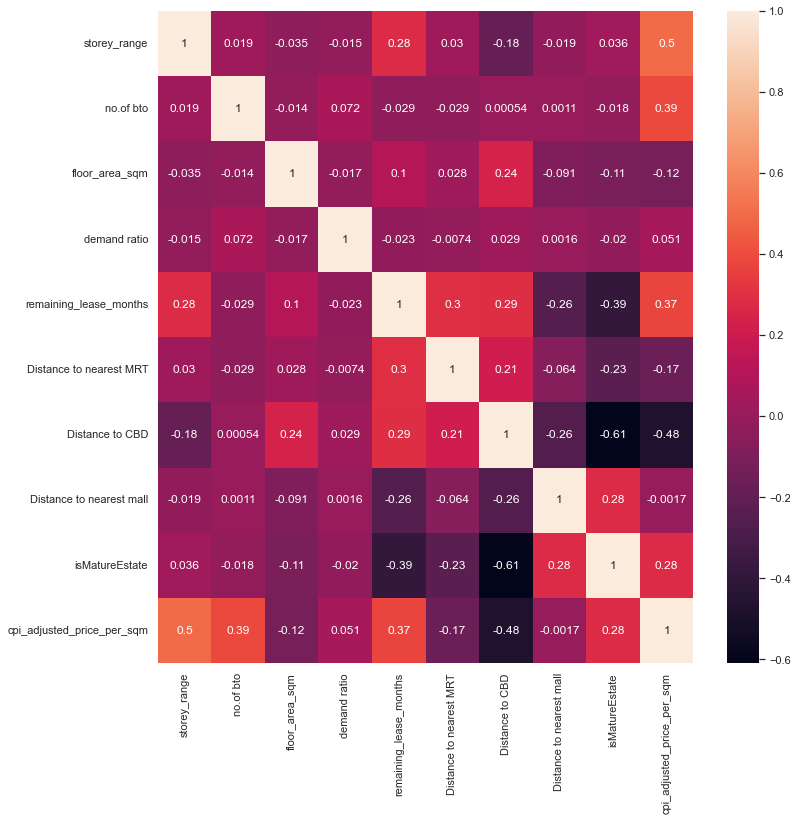

In [14]:
# plot correlation heatpmap 
sns.set (rc = {'figure.figsize':(12, 12)})
sns.heatmap(df_svr.corr(), annot=True)

### Sampling Data for K-Fold Cross Validation

In [13]:
sample_df = df_svr.sample(n=10000, random_state=1)
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 139032 to 129486
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   storey_range                10000 non-null  int64  
 1   no.of bto                   10000 non-null  int64  
 2   floor_area_sqm              10000 non-null  float64
 3   demand ratio                10000 non-null  float64
 4   remaining_lease_months      10000 non-null  int64  
 5   Distance to nearest MRT     10000 non-null  float64
 6   Distance to CBD             10000 non-null  float64
 7   Distance to nearest mall    10000 non-null  float64
 8   isMatureEstate              10000 non-null  int64  
 9   cpi_adjusted_price_per_sqm  10000 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 859.4 KB


In [16]:
# split data into independent and dependent variables
x_sample = df_svr.drop(columns=['cpi_adjusted_price_per_sqm'])
y_sample = df_svr[['cpi_adjusted_price_per_sqm']]

### Comparing Performance of Linear and RBF Kernels

In [21]:
# split data into training and testing sets
# initiatie standard scalers for x and y variables
sc_x = StandardScaler()
sc_y = StandardScaler()

sample_X_train, sample_X_test, sample_y_train, sample_y_test = train_test_split(x_sample, y_sample, test_size = 0.2, random_state = 0)

# standardize x and y values
sample_X_train = sc_x.fit_transform(sample_X_train)
sample_y_train = sc_y.fit_transform(sample_y_train)

In [22]:
sample_X_train

array([[ 0.34644073, -1.31652382,  0.23716048, ...,  0.3730184 ,
        -0.63923168, -0.81134857],
       [-0.63185115,  1.20200159, -1.31584059, ...,  0.99182823,
         1.45452024, -0.81134857],
       [ 0.34644073, -0.04402651,  0.49599399, ...,  1.59029534,
         0.07044722, -0.81134857],
       ...,
       [-0.63185115, -0.04402651,  0.58227183, ...,  0.10222357,
        -1.15574021, -0.81134857],
       [-1.12099709, -0.04402651,  1.05679993, ...,  0.03840014,
        -0.18044264, -0.81134857],
       [ 0.34644073,  1.20200159, -0.23736763, ...,  0.27893022,
         1.18225436, -0.81134857]])

In [23]:
sample_y_train

array([[-1.38027519],
       [ 0.84366218],
       [-0.74534533],
       ...,
       [ 0.57454224],
       [-1.1341246 ],
       [ 0.77895326]])

In [24]:
# Fit the linear kernel model with training data
from sklearn.svm import SVR

regressor = SVR(kernel = 'linear')
regressor.fit(sample_X_train, sample_y_train)

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(kernel='linear')

In [ ]:
# predict resale prices using the model with standardized test data

standardScaler = StandardScaler()
X_test_norm = standardScaler.fit_transform(X_test)

y_pred = regressor.predict(X_test_norm)

y_pred

In [ ]:
# evaluation metrics for SVR with linear kernel

# inverse standardize predicted values
y_pred = sc_y.inverse_transform([y_pred])
y_pred



### K-Fold Cross Validation for Support Vector Regression Model

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR

# Create SVR model
svr_model = SVR(kernel='rbf', C=1, epsilon=0.1)

# Create k-fold cross-validation object
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
# Perform cross-validation for MSE
r2_scores = cross_val_score(svr_model, X, y, cv=kfold, scoring='r2')
print('Cross-validation scores (R2):', r2_scores)

# Calculate average performance metric across all folds
mean_score = r2_scores.mean()

print('Average R2:', mean_score)

In [ ]:
# Perform cross-validation for MSE
mse_scores = cross_val_score(svr_model, X, y, cv=kfold, scoring='neg_mean_squared_error')
print('Cross-validation scores (MSE):', mse_scores)

# Calculate average performance metric across all folds
mean_score = -mse_scores.mean()

print('Average MSE:', mean_score)

In [ ]:
# Perform cross-validation for RMSE
rmse_scores = cross_val_score(svr_model, X, y, cv=kfold, scoring='neg_root_mean_squared_error')
print('Cross-validation scores (RMSE):', rmse_scores)

# Calculate average performance metric across all folds
mean_score = -rmse_scores.mean()

print('Average RMSE:', mean_score)


### Declare Independent and Target Variables

In [ ]:
# declare independent and dependent variables
X = df_svr.drop(columns=['cpi_adjusted_price_per_sqm'])
y = df_svr[['cpi_adjusted_price_per_sqm']]

### Split Data into Training and Test Sets

In [10]:
#Split the dataset into training and testing data

# initiatie standard scalers for x and y variables
sc_x = StandardScaler()
sc_y = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# standardize x and y values
X_train = sc_x.fit_transform(X_train)
y_train = sc_y.fit_transform(y_train)

NameError: name 'X' is not defined

In [ ]:
X_train

In [ ]:
y_train

### Train Support Vector Regression Model

In [ ]:
# Fit the model with training data
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train, y_train)

In [ ]:
# predict resale prices using the model with standardized test data

# standardize test data
standardScaler = StandardScaler()
X_test_norm = standardScaler.fit_transform(X_test)

y_pred = regressor.predict(X_test_norm)

y_pred

### Evaluate Support Vector Regression Model

In [ ]:
# inverse standardize predicted values
y_pred = sc_y.inverse_transform([y_pred])
y_pred

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse**(1/2.0)) 

In [ ]:
# derive r squared score
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred[0])
print("R2 score: " + str(r2))

In [ ]:
# derive mean absolute error
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred[0])

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(y_test, y_pred[0], color = 'purple')

# Add labels and title
plt.title('Predicted Resale Prices Against Actual Resale Prices (SVR)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

plt.show()